In [9]:
import numpy as np
import scipy.stats
import scipy.optimize as op
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import pandas as pd
import seaborn as sns
import random as rand
import os
import collections
import itertools


# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

print "Required modules loaded \n\n" 

Required modules loaded 




In [10]:
# ###
# ### Create a class to hold and store the data 
# ###

# class stellarObject:
#     def __init__(self, name):
#         self.name = name
#         self.data = []
#         self.edges = []
#         self.density = []
#         self.densityError = []
#         self.binsize = []
        


###
### Here we define some functions that are needed for the rest of the data analyses.
###

# Rebin a histogram so there are at least a certain amount of counts per bin (mininbin).
def histrebin(mininbin, counts, edges):
    counts2, edges2 = np.zeros(1), np.zeros(1)
    i, countsum, firstbin_flag = 0, 0, 1
    edges2[0] = edges[0]

    for x in counts:
        countsum = countsum + x
        i = i + 1
        # The sum over counts in remaining bins ensures that no bins
        # with counts less than our limit at the end are obtained.
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):
            # If this is the first bin satisfying the requirement,
            # do not append but replace bin 0 with countsum instead.
            if firstbin_flag == 1:
                counts2[0] = countsum
                # Now that the first bin was read this can be switched off.
                firstbin_flag = 0
            else:
                counts2=np.append(counts2, countsum)

            edges2 = np.append(edges2, edges[i])
            countsum = 0        

    return counts2, edges2



###
### define our functional models
###

def add_emmision_line(E, lineNormalisation, lineEnergie):
    sigma = 0.06*np.sqrt(lineEnergie)
    return scipy.stats.norm.pdf(E, lineEnergie, sigma)*lineNormalisation

def model_ULX1(parm, E): 
    N0 = parm[0]
    E0 = parm[1]
    Ebk = parm[2]
    Gamma1 = parm[3]
    Gamma2 = parm[4]
    if E <= Ebk:
        return N0 * (E / E0)**(-Gamma1)
    else:
        return N0 * (Ebk / E0)**(-Gamma1) * (E / Ebk)**(-Gamma2)

def model_ULX2(parm, EList):
    def func(E):
        return N0 * (E / E0)**(-Gamma) * np.exp(-E / Ecut)
        
    N0 = parm[0]
    E0 = parm[1]
    Ecut = parm[2]
    Gamma = parm[3]
    return func(EList)


def model_SNR(parm, EList):
    def func(E):
            return N0  + E**(-Gamma)
        
    Nbase = parm[0]
    N0 = parm[1]
    Gamma = parm[2]
    Si13Strength = parm[3]
    Si15Strength = parm[4]
    FeStrength = parm[5]

    return func(EList) + add_emmision_line(EList, Si13Strength, 1.83) + \
add_emmision_line(EList, Si15Strength, 2.4) + add_emmision_line(EList, FeStrength, 6.7)


def model_XRB(parm, EList):
    def func(E):
            return N0 * (E / E0)**(2) / ( np.exp(E / KbT) - 1)
        
    N0 = parm[0]
    E0 = parm[1]
    KbT = parm[2]
    return func(EList)


def model_AGN1(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    return func(EList)

def model_AGN2(parm, EList):
    def func(E):
            return N0 * E**(-Gamma)
        
    N0 = parm[0]
    Gamma = parm[1]
    FeStrength = parm[2]
    return func(EList) + add_emmision_line(EList, FeStrength, 6.7)


def ChiSq_Integ(parm, ebins, yval, dy, model): # the weighted least-squares for an array of upper and lower bin edges
    # (xval1 and xval2) fitted with the integral over the bin of the generic model my_fit_model
    i = 0
    ymod = np.zeros(len(yval))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: model(parm, x),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1

    return sum(pow((yval-ymod)/dy,2))

###
### Define our fit statistic function, set up to deal with all distributions using if statements
###
def controler(parm, x, y, dy, binsize, model, printProgres=False):
    def printProgresFunc():
        if printProgres:
            print parm        
            print X
            print "\n\n"
    
    if(model == "ULX1"):
        X = ChiSq_Integ(parm, x, y, dy, model_ULX1)
        printProgresFunc()          
        return(X)
    
    elif(model == "ULX2"):
        X = ChiSq_Integ(parm, x, y, dy, model_ULX2)
        printProgresFunc()             
        return(X)
    
    elif(model == "SNR"):
        X = ChiSq_Integ(parm, x, y, dy, model_SNR)
        printProgresFunc()
        return(X)  
    
    elif(model == "XRB"):
        X = ChiSq_Integ(parm, x, y, dy, model_XRB)
        printProgresFunc()
        return(X)
       
    elif(model == "AGN1"):
        X = ChiSq_Integ(parm, x, y, dy, model_AGN1)
        printProgresFunc()
        return(X)
        
    elif(model == "AGN2"):
        X = ChiSq_Integ(parm, x, y, dy, model_AGN2)
        printProgresFunc()
        return(X)

    else:
        assert False



In [11]:
data = np.genfromtxt("energies.txt", dtype=float, skip_header=0, autostrip=True, usecols=(0,1))

sources = {i:[] for i in range(1,11)}
for source, dataPoint in data:
    sources[source].append(dataPoint)


# error is same as in PS4 BLA BLA BLA
Eerst convert ik hist naar een cdf, 

In [12]:
edgesDict, densityDict, errorDict, binsizeDict = {}, {}, {}, {}
minNCounts = 20 

for sourceNumber in sources.keys():
    data = sources[sourceNumber]
    counts, edges = np.histogram(data, bins=100, range=[np.min(data),np.max(data)], density=False)
    counts, edges = histrebin(minNCounts, counts, edges)
    
    counts = counts[counts>minNCounts]
    edges = edges[0:len(counts)+1]
    
    binsize = np.diff(edges) # calculates the width of each bin
    dens = counts/binsize # determines the count densities
    err = np.sqrt(counts)/binsize # calculate the errors: remember the error is based on the counts,         


    ###
    ### Renormalize
    ###
    edgesDict[sourceNumber] = edges[0:len(counts)]
    densityDict[sourceNumber] = dens/max(dens)
    errorDict[sourceNumber] = err/max(dens)
    binsizeDict[sourceNumber] = binsize



# Fit
Dan vit ik hem aan verschillende modellen


Starting annalysis



ULX1
Minimum Chi-squared: 93.0612592825 for 54 d.o.f.
The goodness of fit is: 0.000760229877639
Parameters:  [ 1.04083754  1.08398798  7.43415908  1.94419179  2.60276781]

ULX2
Minimum Chi-squared: 106.816131627 for 55 d.o.f.
The goodness of fit is: 3.55930529296e-05
Parameters:  [  0.92294483   1.20502418  10.           1.64435623]

SNR
Minimum Chi-squared: 354353.932964 for 53 d.o.f.
The goodness of fit is: 0.0
Parameters:  [ 0.1        0.2        3.         0.0106013  0.         0.       ]

XRB
Minimum Chi-squared: 2379.38704016 for 56 d.o.f.
The goodness of fit is: 0.0
Parameters:  [ 1.34046165  0.88135671  0.62703658]

AGN1
Minimum Chi-squared: 121.966409029 for 57 d.o.f.
The goodness of fit is: 1.26123071682e-06
Parameters:  [ 1.25787372  2.00577129]

AGN2
Minimum Chi-squared: 121.966409029 for 56 d.o.f.
The goodness of fit is: 8.39101854387e-07
Parameters:  [ 1.2578737   2.00577129  0.        ]




ULX1
Minimum Chi-squared: 132.749394864 for 56 d.o.f.
The g

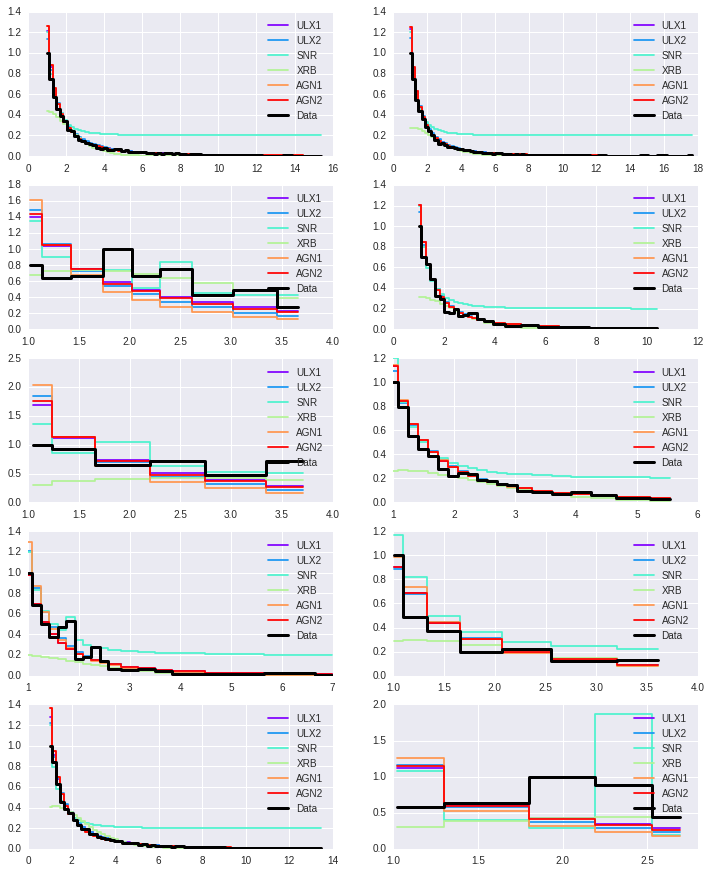

done


In [13]:
f, axes = plt.subplots(5,2,figsize=(12,15))
print "Starting annalysis"
sourceList = ["ULX1", "ULX2", "SNR", "XRB", "AGN1", "AGN2"]
# sourceList = ["ULX1", "ULX2", "XRB", "AGN1"]  # Without emmission
colorsList = itertools.cycle(cm.rainbow(np.linspace(0, 1, len(sourceList))))

startingParmList = []
for i in range(5):
    for j in range(2):
        ax = axes[i][j]
        k = 2 * i + j + 1
        
        print "\n\n\n============================================="
        for source in sourceList:
            if source == "ULX1":
                startingParm = [1, 1, 7, 1.8, 2.8]
                result = op.minimize(controler, startingParm, args=(edgesDict[k][:len(densityDict[k])], densityDict[k], 
                                                                    errorDict[k], binsizeDict[k], "ULX1"), 
                                     bounds=((densityDict[k][0]/2., None), (.1, None), (5, 10), (1.4, 2.2), (2.4, 3.2)))
            
            elif source == "ULX2":
                startingParm = [1, 1, 7, 2]
                result = op.minimize(controler, startingParm, args=(edgesDict[k][:len(densityDict[k])], densityDict[k], 
                                                                    errorDict[k], binsizeDict[k], "ULX2"), 
                                     bounds=((densityDict[k][0]/2., None), (0.1, None), (4, 10), (1.5, 3.2)))
                      
            elif source == "SNR":
                startingParm = [.1, 1, 2.5, .3, .3, .1]
                result = op.minimize(controler, startingParm, args=(edgesDict[k][:len(densityDict[k])], densityDict[k], 
                                                                    errorDict[k], binsizeDict[k], "SNR"), 
                                     bounds=((0, None), (densityDict[k][0]/5., None), (2, 3), (0, None), (0, None), (0, None)))                
                
            elif source == "XRB":
                startingParm = [1, 1, 7]
                result = op.minimize(controler, startingParm, args=(edgesDict[k][:len(densityDict[k])], densityDict[k], 
                                                                    errorDict[k], binsizeDict[k], "XRB"), 
                                     bounds=((densityDict[k][0]/2., None), (0, None), (.6, 1.6)))                
            
            elif source == "AGN1":
                startingParm = [1, 2.2]
                result = op.minimize(controler, startingParm, args=(edgesDict[k][:len(densityDict[k])], densityDict[k], 
                                                                    errorDict[k], binsizeDict[k], "AGN1"), 
                                     bounds=((densityDict[k][0]/2., None), (2, 2.7)))                   
                
            elif source == "AGN2":
                startingParm = [1, 1.6, .3]
                result = op.minimize(controler, startingParm, args=(edgesDict[k][:len(densityDict[k])], densityDict[k], 
                                                                    errorDict[k], binsizeDict[k], "AGN2"), 
                                     bounds=((densityDict[k][0]/2., None), (1.5, 2.2), (0, None))) 
            
            else:
                print "Source {} is not implemented!".format(source)
                assert False
        

            ###
            ### Get usefull info from the fit such as pval and used parameters
            ###
            ml_vals = result["x"]
            ml_func = result["fun"]
        
        
            ###
            ### Plot the fits
            ###
            xList = edgesDict[k]
            yList = [eval("model_"+source)(ml_vals, x) for x in xList]         
            ax.plot(xList, yList, linestyle="steps-mid", color=next(colorsList), label=source)
#             ax.plot(xList, yList, color=next(colorsList), label=source)

            
            ###
            ### Output results
            ###
            
            pval = scipy.stats.chi2.sf(ml_func, df=len(densityDict[k]) - len(startingParm))
            print source
            print "Minimum Chi-squared: {} for {} d.o.f.".format(ml_func,len(densityDict[k])-len(startingParm))
            print "The goodness of fit is: {}".format(pval)
            print "Parameters: ", ml_vals
            if pval>0.05:
                print "<====================== This could be a: {}".format(source) 
            print ""

            
        # Plot original 
        ax.plot(edgesDict[k], densityDict[k], lw=3, color="k", linestyle="steps-mid", label="Data")
#         ax.errorbar(edgesDict[k], densityDict[k], xerr=binsizeDict[k]/2., yerr=errorDict[k], lw=3, color="k", label="Data")

        ax.legend()
plt.show()
print "done"

<table style="width:100%">
  <tr>
    <th>Firstname</th>
    <th>Lastname</th> 
    <th>Age</th>
  </tr>
  <tr>
    <td>Jill</td>
    <td>Smith</td> 
    <td>50</td>
  </tr>
  <tr>
    <td>Eve</td>
    <td>Jackson</td> 
    <td>94</td>
  </tr>
</table>

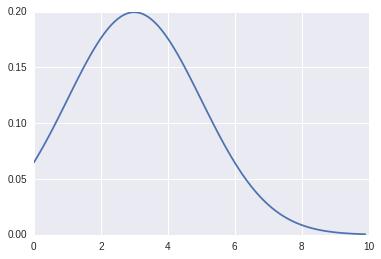

In [14]:
x = np.arange(0,10,.1)
y = scipy.stats.norm.pdf(x, 3, 2)
# scipy.stats.norm.pdf(x, mean, std)
plt.plot(x,y)
